In [1]:
# ========== IMPORTS ==========
import numpy as np
import matplotlib.pyplot as plt
import torch

from nerf_synthetic_dataset import NeRFSyntheticDatasetRays
from torch.utils.data import DataLoader

In [2]:
# ========== CONSTANTS ==========
# ---- Training constants ----
# Embedding space dimensions per embedding function for sample points x.
L_EMBED_X = 6
# Embedding space dimensions per embedding function for ray directions d.
L_EMBED_D = 4
# Number of rays to be simultaneously processed by net.
CHUNK_SIZE = 1024 #*32
# Number of samples along one ray.
N_SAMPLES = 100
# Number of epochs.                
N_ITERS = 100
# Size of all dense layers in nerf network, besides the last 2 layers.
DENSE_LAYER_SIZE = 128
# Learning rate used during training.
LEARNING_RATE = 1e-3
# Weight decay used for AdamW
WEIGHT_DECAY = 1e-4
# Device to train on.
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Image downscale factor
IMG_DOWNSCALE = 16
# Amount of rays being fed through the net
BATCH_SIZE = 10000

# ---- Paths ----
# Path to training data.
PATH_TO_DATA = 'example_training_data/large_lego_bulldozer/'
# Path used to save and load trained (coarse) model.
PATH_TO_MODEL = 'tiny_nerf.pth'
# Path used to save and load trained fine model.
PATH_TO_FINE_MODEL = '' #'tiny_nerf_fine.pth'
# Path used to save the 360° video to.
PATH_TO_GIF = 'tiny_nerf.gif'

# ---- Scene constants ----
# Nearest/farthest distance to camera to sample.
NEAR, FAR = 2., 6.

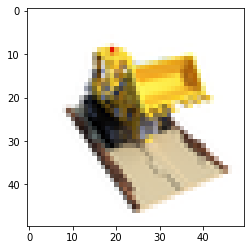

In [3]:
# ========== LOAD DATA ==========
# Load data in form of rays
train_dataset = NeRFSyntheticDatasetRays(root_dir=PATH_TO_DATA,
                                         split='train',
                                         img_downscale=IMG_DOWNSCALE)

test_dataset = NeRFSyntheticDatasetRays(root_dir=PATH_TO_DATA,
                                        split='test',
                                        img_downscale=IMG_DOWNSCALE)

H, W = train_dataset.get_h_w()

# Plot one sample.
TEST_ID = 42
sample = test_dataset[TEST_ID*H*W:(TEST_ID+1)*H*W]
TEST_RAYS_O, TEST_RAYS_D = sample['rays_o'], sample['rays_d']
TEST_IMG = sample['pixel_cols']

plt.imshow(TEST_IMG.view(H, W, 3))
plt.show()

In [4]:
# ========== HELPER FUNCTIONS ==========

# Simulates the behaviour of tf.cumprod(..., exclusive=True) in torch
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
    cumprod = torch.cumprod(tensor, -1)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, -1)
    # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.
    return cumprod

# Positional encoding function (as in NeRF paper page 7, but without pi).
# Function is applied to each dimension of x separately.
# Results in a output shape of [... x 3*2*L_embed+3].
def positional_encoding(x, L_embed):
    rets = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn((2. ** i) * x))
    return torch.cat(rets, -1)

# Run network on query points and their corresponding ray direction.
#   net:    NeRF network
#   pts:    query points
#   rays_d: ray directions from get_rays
def run_net(net, pts, rays_d):
    if next(net.parameters()).is_cuda:
        pts = pts.to(DEVICE)
        rays_d = rays_d.to(DEVICE)
    
    # --- Embed and flatten query points.
    pts_flat = pts.reshape((-1, 3))
    pts_embed = positional_encoding(pts_flat, L_EMBED_X)
    
    # --- Embed and flatten ray directions.
    rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True) # normalize ray length
    rays_d = rays_d[:, None, :].repeat(1, pts.shape[1], 1) # each query point should have one ray direction
    rays_d_flat = rays_d.reshape((-1, 3))
    rays_d_embed = positional_encoding(rays_d_flat, L_EMBED_D)
    
    # --- Run network, CHUNK_SIZE-sized batches at a time.
    raw = torch.cat([net(pts_embed[i:i+CHUNK_SIZE], rays_d_embed[i:i+CHUNK_SIZE]) for i in range(0, pts_embed.shape[0], CHUNK_SIZE)], 0)
    raw = torch.reshape(raw, list(pts.shape[:-1]) + [4]) # (H*W*N_SAMPLES x 4)
    
    return raw

# Perform volume rendering on the networks raw output.
#   raw:    RGB and opacity values predicted by the network
#   z_vals: z values of sampled points computed by sample_stratified/sample_hierarchical
def volume_rendering(raw, z_vals, rays_d):
    # --- Extract RGB and opacity values from network output.
    rgb = raw[..., :3]
    sigma = raw[..., 3]
    
    # --- Difference between consecutive elements of z_vals.
    z_vals = z_vals.to(rgb.device)
    infinity = torch.Tensor([1e10]).to(rgb.device)
    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1],
                      torch.broadcast_to(infinity, z_vals[..., :1].shape)], 
                      dim=-1)
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1).to(rgb.device) # accounts for normalized input ray lengths
    
    # --- Predict density of each sample along each ray, higher values imply higher likelihood of being absorbed at this point.
    alpha = 1. - torch.exp(-sigma * dists)
    
    # --- Compute weight for RGB value of each sample along each ray; The higher alpha, the lower subsequent weights are driven.
    # --- Small epsilon makes sure, that we don't compute 0.
    epsilon = 1e-10
    weights = alpha * cumprod_exclusive(1. - alpha + epsilon)

    # --- Compute different maps for visualization.
    rgb_map = torch.sum(weights[..., None] * rgb, -2)
    depth_map = torch.sum(weights * z_vals, -1)
    acc_map = torch.sum(weights, -1)

    return rgb_map, depth_map, acc_map, weights

In [5]:
# ========== RAY SAMPLING ==========

# --------- STRATIFIED ---------
# Stratified sampling of 3D query points, where each samples lies within one of evenly spaced bin on a ray.
#   rays_o: ray origins from get_rays
#   rays_d: ray directions from get_rays
#   rand:   if True, the samples lie randomly within each bin; enables the network to learn continuous opacities and RGB values
def sample_stratified(rays_o, rays_d, rand=False):
    # --- Sample linearly between 'near' and 'far', results in evenly spaced bins along the ray.
    t_vals = torch.linspace(0., 1., N_SAMPLES)
    z_vals = NEAR * (1.-t_vals) + FAR * (t_vals)
    # --- If rand=True, then sample one point uniformly within each bin.
    if rand:
        mids = .5 * (z_vals[1:] + z_vals[:-1])
        upper = torch.cat((mids, z_vals[-1:]), dim=-1)
        lower = torch.cat((z_vals[:1], mids), dim=-1)
        t_rand = torch.rand([N_SAMPLES])
        z_vals = lower + (upper - lower) * t_rand
    z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [N_SAMPLES])
    
    # --- Apply scale from 'rays_d' and offset from 'rays_o' to samples.
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    
    return pts, z_vals

# --------- HIERARCHICAL ---------
# Determine PDF from previous point weights, estimate dense sampling, where there is a high likelihood of significant contribution
# to the rendered image.
#   bins:       bin sized of previous z_vals
#   weights:    previously computed sample points weights during rendering
def sample_pdf(bins, weights, rand=False):
    epsilon = 1e-5

    # Normalize weights to get PDF (probability density function).
    pdf = (weights + epsilon) / torch.sum(weights + epsilon, -1, keepdims=True)

    # PDF to CDF (cumulative distribution function).
    cdf = torch.cumsum(pdf, dim=-1)
    cdf = torch.concat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1)

    # Sample positions from CDF.
    if not rand:
        pos = torch.linspace(0., 1., N_SAMPLES, device=cdf.device)
        pos = pos.expand(list(cdf.shape[:-1]) + [N_SAMPLES])
    else:
        pos = torch.rand(list(cdf.shape[:-1]) + [N_SAMPLES], device=cdf.device) 

    # Find indices along CDF where values in pos would be placed
    pos = pos.contiguous() # contiguous in memory
    id = torch.searchsorted(cdf, pos, right=True)

    # Remove out of bounds indices.
    below = torch.clamp(id - 1, min=0)
    above = torch.clamp(id, max=cdf.shape[-1] - 1)
    id_g = torch.stack([below, above], dim=-1) # [n_rays, N_SAMPLES, 2]

    # Sample from CDF given bin centers.
    res_shape = list(id_g.shape[:-1]) + [cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(-2).expand(res_shape),
                         dim=-1,
                         index=id_g)
    bins = bins.to(id_g.device)
    bins_g = torch.gather(bins.unsqueeze(-2).expand(res_shape),
                          dim=-1,
                          index=id_g)

    # Samples to ray length.
    denominator = (cdf_g[..., 1] - cdf_g[..., 0])
    denominator = torch.where(denominator < epsilon,
                              torch.ones_like(denominator),
                              denominator)
    t = (pos - cdf_g[..., 0]) / denominator
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples

# Hierarchical sampling of 3D query points, where each samples lies within one of evenly spaced bin on a ray.
#   rays_o:     ray origins from get_rays
#   rays_d:     ray directions from get_rays
#   z_vals:     previously sampled z values
#   weights:    previously computed sample points weights during rendering
#   rand:       if True, the samples lie randomly within each bin; enables the network to learn continuous opacities and RGB values
def sample_hierarchical(rays_o, rays_d, z_vals, weights, rand=False):
    # Using previous z values, compute new z values using estimated PDF.
    z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
    new_z_samples = sample_pdf(bins=z_vals_mid,
                               weights=weights[..., 1:-1],
                               rand=rand)
    new_z_samples = new_z_samples.detach()

    # Resample points.
    z_vals = z_vals.to(new_z_samples.device)
    z_vals_combined, _ = torch.sort(torch.cat([z_vals, new_z_samples], dim=-1), dim=-1)
    rays_o = rays_o.to(z_vals_combined.device)
    rays_d = rays_d.to(z_vals_combined.device)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]
    
    return pts, z_vals_combined, new_z_samples

In [6]:
# ========== FORWARD PASS ==========

def forward(model, fine_model, rays_o, rays_d):
    # --- Coarse model training ---
    # Compute STRATIFIED 3D query points.
    pts, z_vals = sample_stratified(rays_o, rays_d, rand=True)
    raw = run_net(model, pts, rays_d)
    rgb_map, depth_map, acc_map, weights = volume_rendering(raw, z_vals, rays_d)

    # --- Fine model training ---
    if fine_model is not None:
        # Compute HIERARCHICAL 3D query points depending on output of coarse network.
        pts, z_vals_combined, new_z_vals = sample_hierarchical(rays_o, rays_d, z_vals, weights, rand=True)
        raw = run_net(fine_model, pts, rays_d)
        rgb_map, depth_map, acc_map, _ = volume_rendering(raw, z_vals_combined, rays_d)
    
    return rgb_map, depth_map, acc_map

In [7]:
# ========== MODEL ==========
# Tiny variant of the NeRF network. Has fewer and potentially smaller layers.
class Tiny_NeRF(torch.nn.Module):
    def __init__(self, dense_layer_size=128):
        super(Tiny_NeRF, self).__init__()

        self.leaky_relu = torch.nn.LeakyReLU() # go-to activation function
        self.relu = torch.nn.ReLU() # activation function for opacity
        self.sigmoid = torch.nn.Sigmoid() # activation function for RGB value
        
        self.dense1 = torch.nn.Linear(3 + 3*2*L_EMBED_X, dense_layer_size)
        self.dense2 = torch.nn.Linear(dense_layer_size, dense_layer_size)
        self.dense3 = torch.nn.Linear(dense_layer_size, dense_layer_size)
        self.dense4 = torch.nn.Linear(dense_layer_size + 3 + 3*2*L_EMBED_X, dense_layer_size)
        self.dense5 = torch.nn.Linear(dense_layer_size, dense_layer_size)
        self.dense6 = torch.nn.Linear(dense_layer_size, dense_layer_size + 1)
        self.dense7 = torch.nn.Linear(dense_layer_size + 3 + 3*2*L_EMBED_D, int(dense_layer_size/2))
        self.dense8 = torch.nn.Linear(int(dense_layer_size/2), 3)

    def forward(self, x, d):
        y = self.leaky_relu(self.dense1(x))
        y = self.leaky_relu(self.dense2(y))
        y = self.leaky_relu(self.dense3(y))
        
        # Attach embedded point positions.
        y = torch.cat((y, x), -1)
        
        y = self.leaky_relu(self.dense4(y))
        y = self.leaky_relu(self.dense5(y))
        y = self.dense6(y)
        
        # Extract opacity, which is the first dimension.
        sigma = self.relu(y[...,0])
        y = y[..., 1:]

        # Attach embedded viewing direction.
        y = torch.cat((y, d), -1)
        
        y = self.leaky_relu(self.dense7(y))
        rgb = self.sigmoid(self.dense8(y))
        
        # Combine RGB and opacity value to one output.   
        out = torch.cat((rgb, sigma.unsqueeze(-1)), -1)

        return out

In [8]:
# ========== TRAINING HELPERS ==========

# Training procedure.
#   model:      NeRF model or coarse model, if using a fine model
#   fine_model: fine model to build on the results of model; is None, if only coarse model should be used
#   optim:      optimizer working on both model and fine model parameters
#   restart:    consider restarting, if image remains black after 2 epochs.
def train_models(model, fine_model, optim, restart=True):
    model.train()
    if fine_model is not None:
        fine_model.train()

    psnrs = []
    iternums = []
    loss_list = []
    
    # Keep track, in which iteration we broke of the training procedure.
    it = 0

    train_dataloader = DataLoader(train_dataset,
                                  shuffle=True,
                                  batch_size=BATCH_SIZE)
    
    for epoch in range(N_ITERS): 
        running_loss = 0.0
        for _, batch in enumerate(train_dataloader):
            rays_o = batch['rays_o']
            rays_d = batch['rays_d']
            gt_pixel_cols = batch['pixel_cols'].to(DEVICE)

            pred_pixel_cols, _, _ = forward(model, fine_model, rays_o, rays_d)
            loss = torch.nn.functional.mse_loss(pred_pixel_cols, gt_pixel_cols)

            running_loss += loss.item()

            optim.zero_grad()
            loss.backward()
            optim.step()
        running_loss /= len(train_dataset) // BATCH_SIZE#  compute mean loss over entire dataset

        # Intermediate visualization of training process.
        with torch.no_grad():
            # Render the holdout view.
            rgb, _, _ = forward(model, fine_model, TEST_RAYS_O, TEST_RAYS_D)

            plt.figure(figsize=(20, 4))
            plt.subplot(141)
            plt.imshow(rgb.view(H, W, 3).cpu().detach())
            plt.title(f'Iteration: {epoch}')
            
            plt.subplot(142)
            plt.imshow(TEST_IMG.view(H, W, 3))
            plt.title('Traget')

            # Plot Peak-to-Noise ratio curve over the training. Larger is better.
            # Formula: (MAX is maximal pixel value, which is 1.0 in our case)
            #       PSNR = 20*log_10(MAX) - 10*log_10(MSE)
            psnr = -10. * np.log(running_loss) / np.log(10.)
            psnrs.append(psnr)
            
            iternums.append(epoch)

            plt.subplot(143)
            plt.plot(iternums, psnrs)
            plt.title('Train Mean PSNR')
            
            loss_list.append(running_loss)
            
            plt.subplot(144)
            plt.plot(iternums, loss_list)
            plt.title('Train MSE Loss')

            plt.show()
            
            # If test image remains mostly black after some iterations, consider to restart training.
            if restart and torch.sum(rgb.cpu().detach()) < 1e-4 and epoch > 1:
                break
            
        it += 1

        # Intermediate saving of the models.
        if fine_model is not None and PATH_TO_FINE_MODEL:
            torch.save(fine_model.state_dict(), PATH_TO_FINE_MODEL)
        torch.save(model.state_dict(), PATH_TO_MODEL)
            
    return it

def train(use_fine_model=False, restart=True):
    it = 0
    # it < N_ITERS-1, if training was prematurely ended.
    while(it < N_ITERS-1):
        model = Tiny_NeRF(DENSE_LAYER_SIZE).to(DEVICE)
        model_params = list(model.parameters())

        if use_fine_model:
            fine_model = Tiny_NeRF(DENSE_LAYER_SIZE).to(DEVICE)
            model_params = model_params + list(fine_model.parameters())
        else:
            fine_model = None

        optim = torch.optim.AdamW(model_params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

        it = train_models(model, fine_model, optim, restart)
    
    print('Training done!')

    return model, fine_model

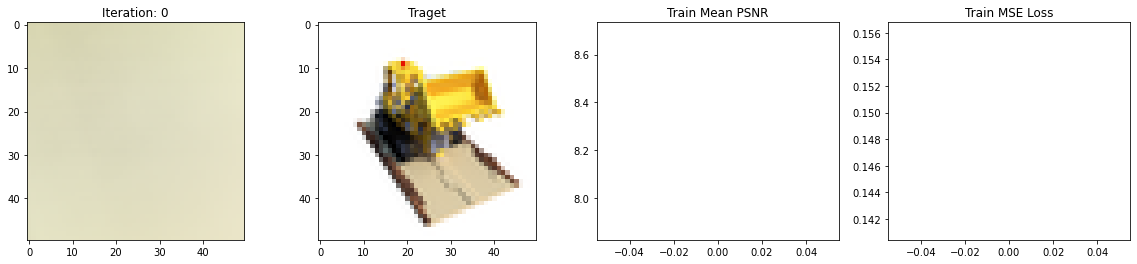

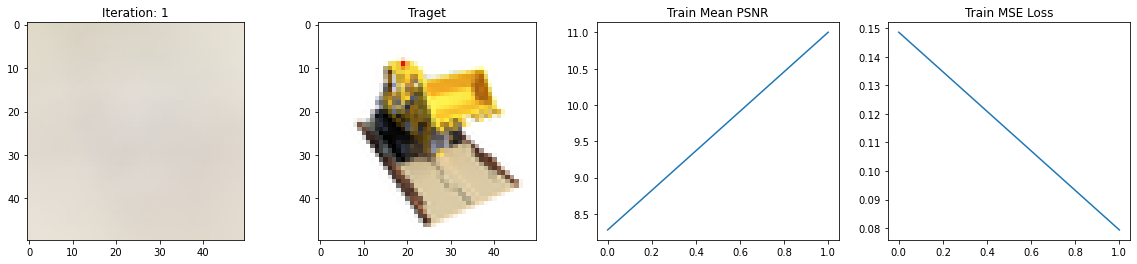

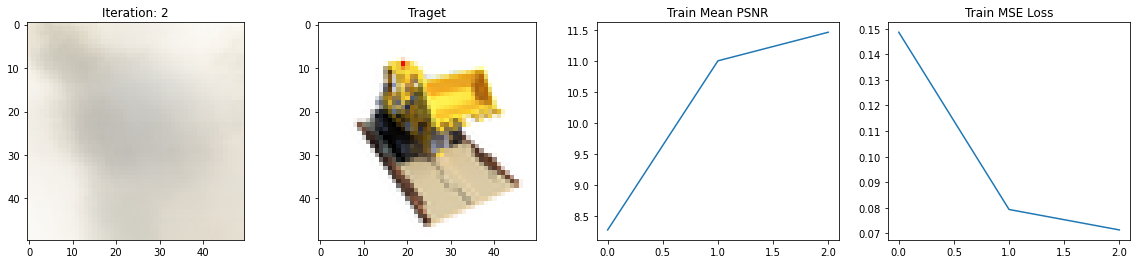

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


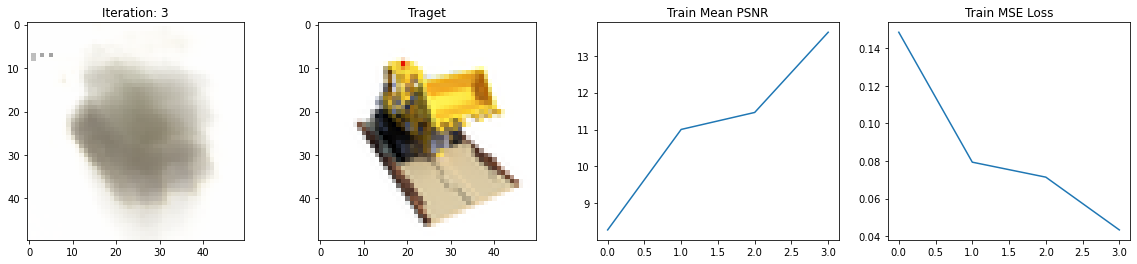

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


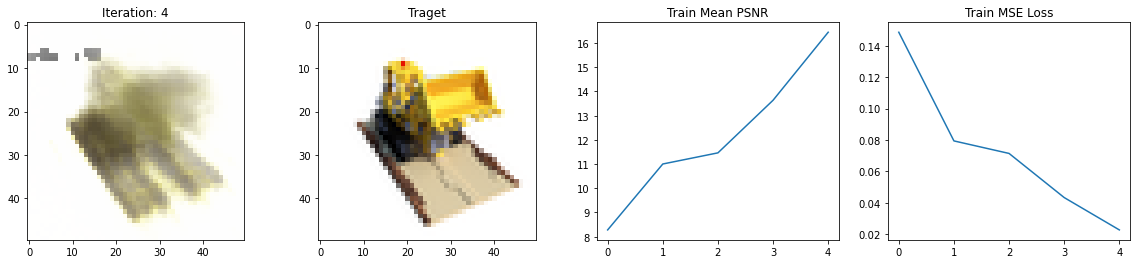

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


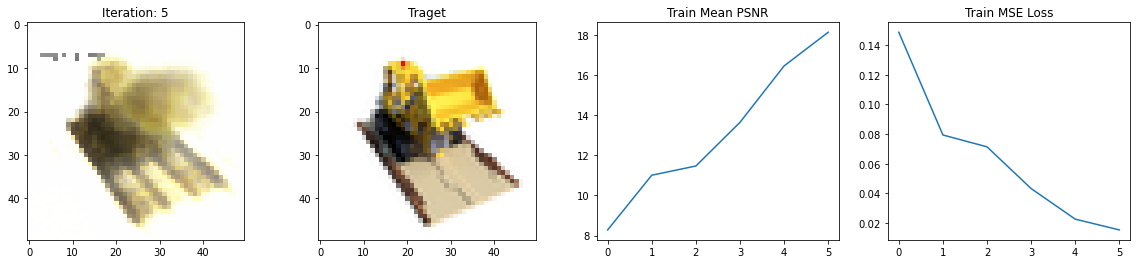

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


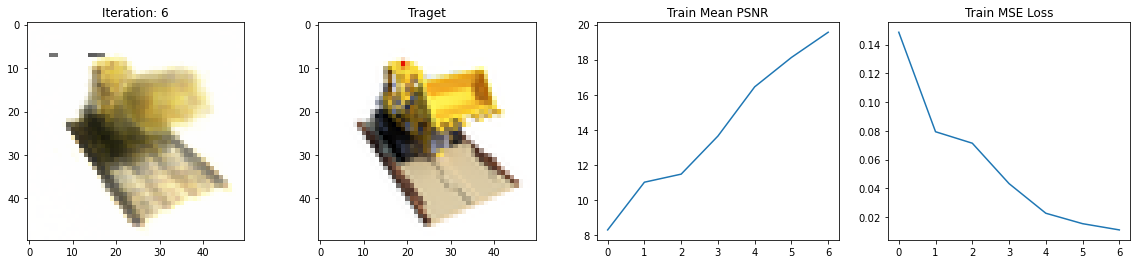

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


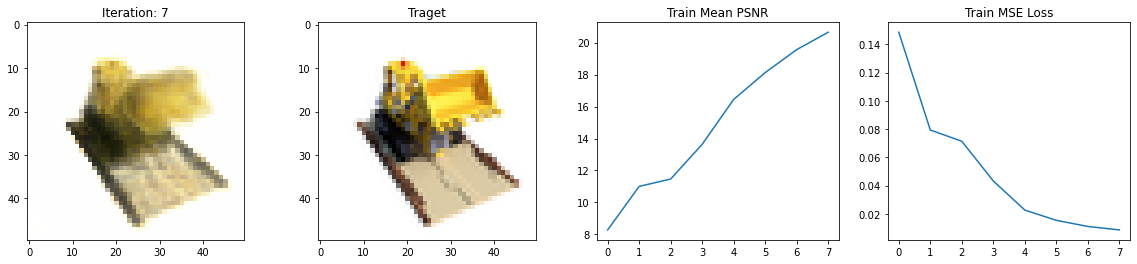

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


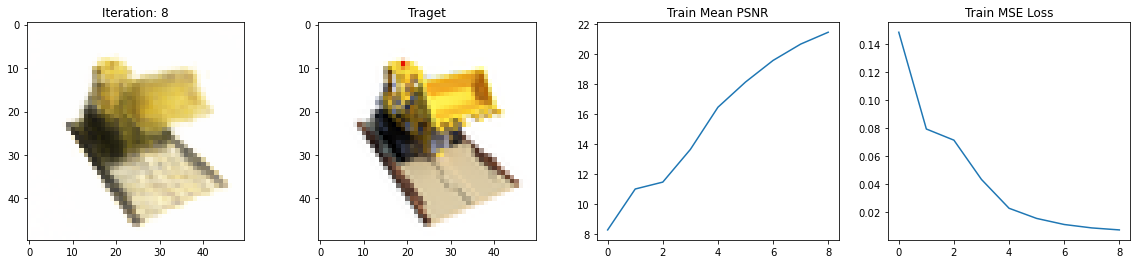

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


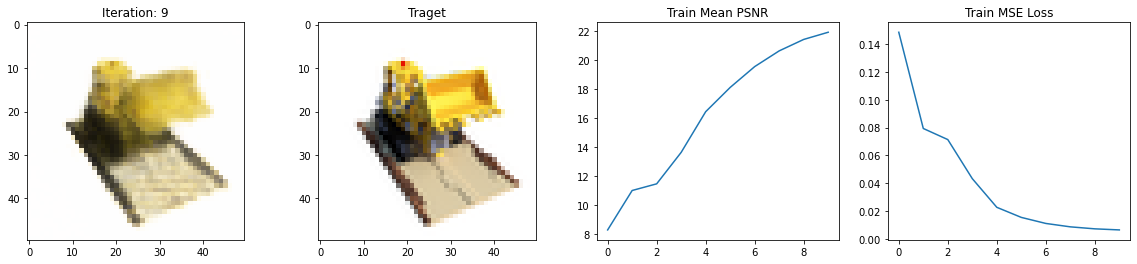

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


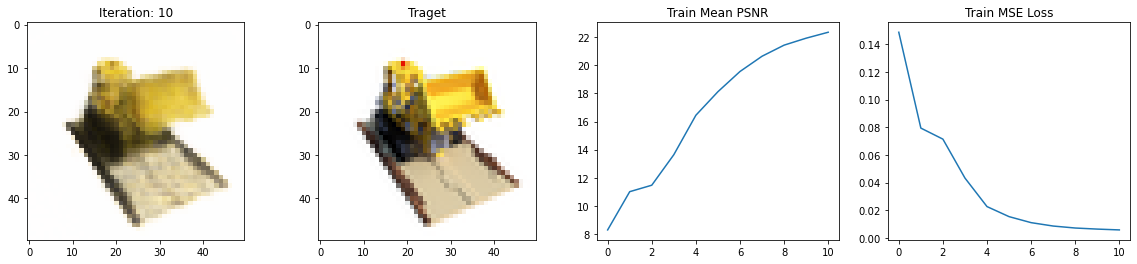

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


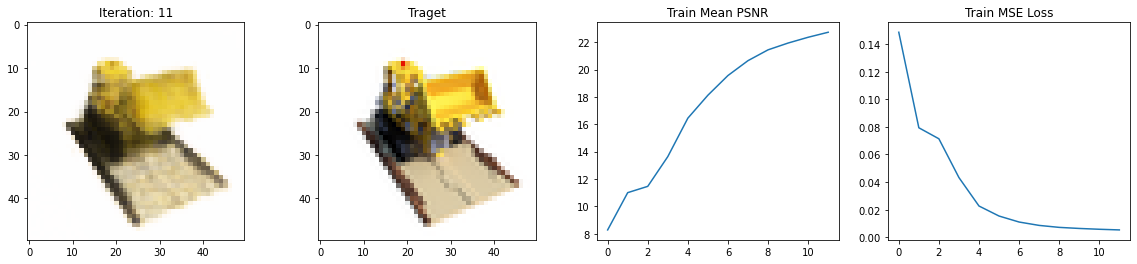

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


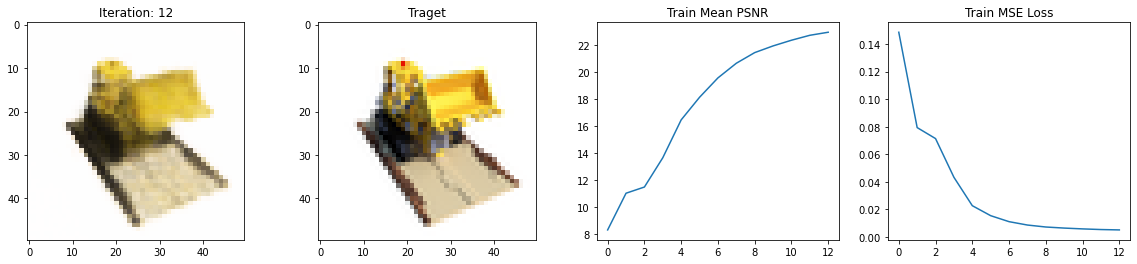

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


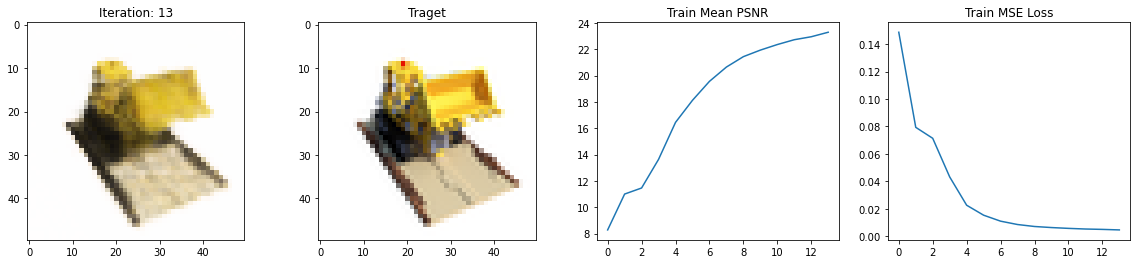

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


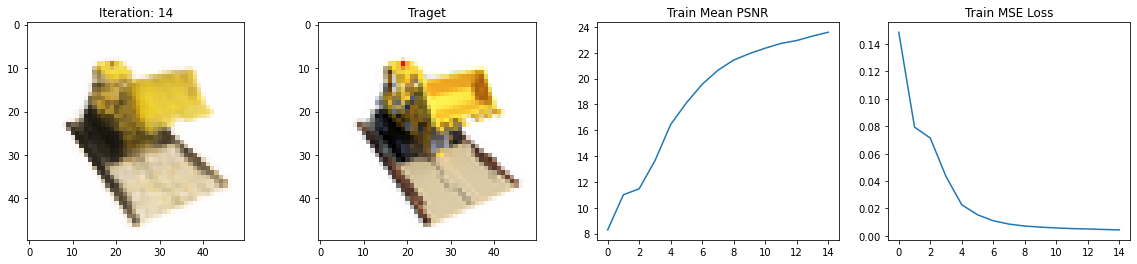

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


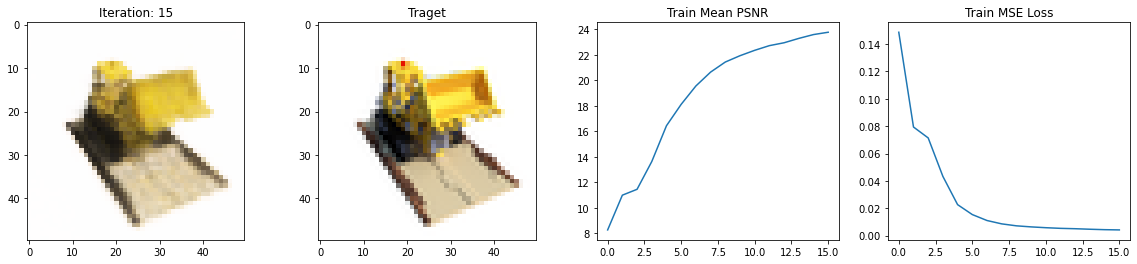

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


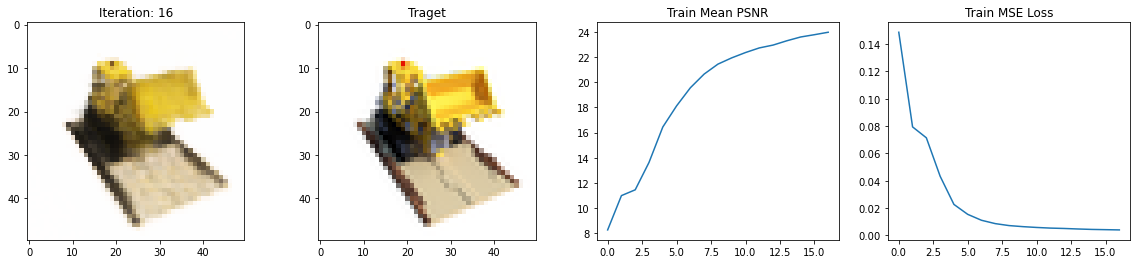

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


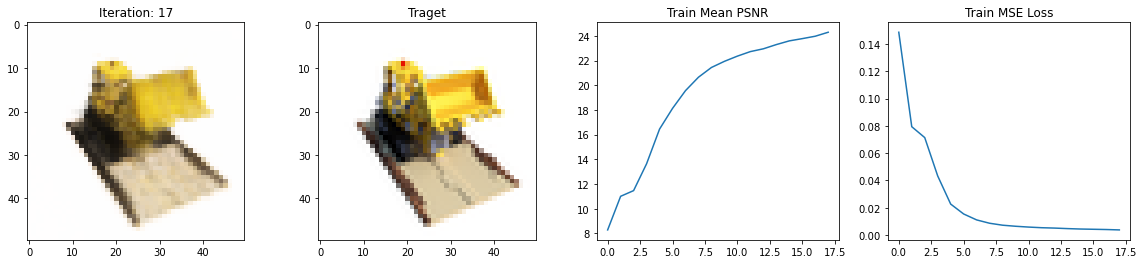

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


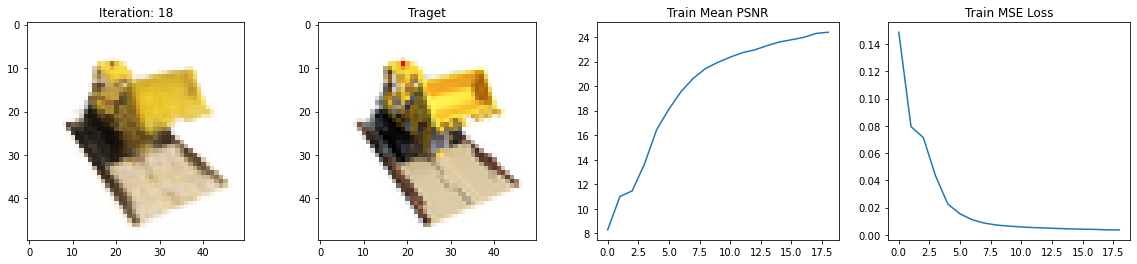

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


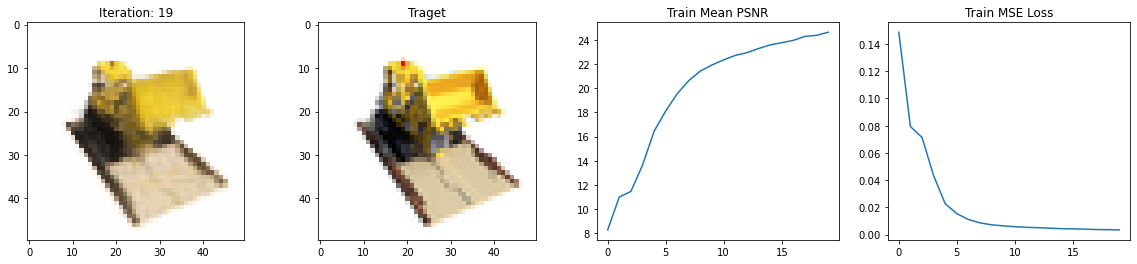

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


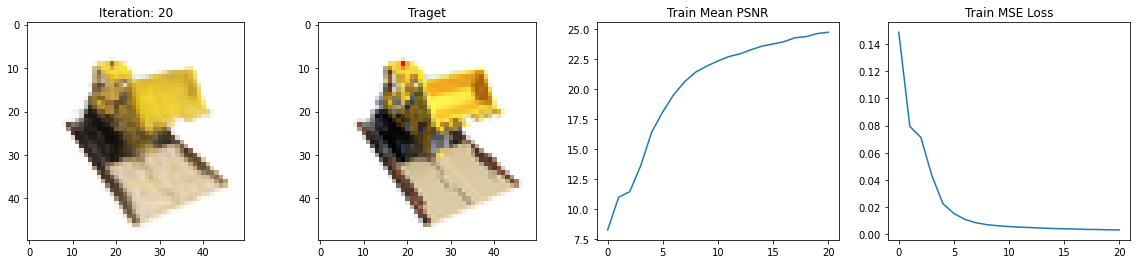

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


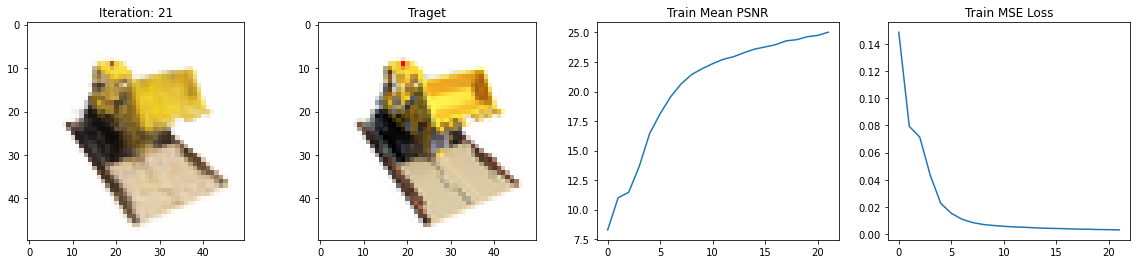

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


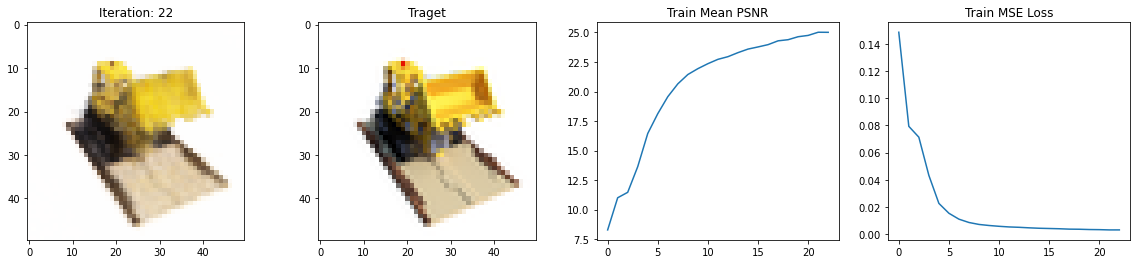

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


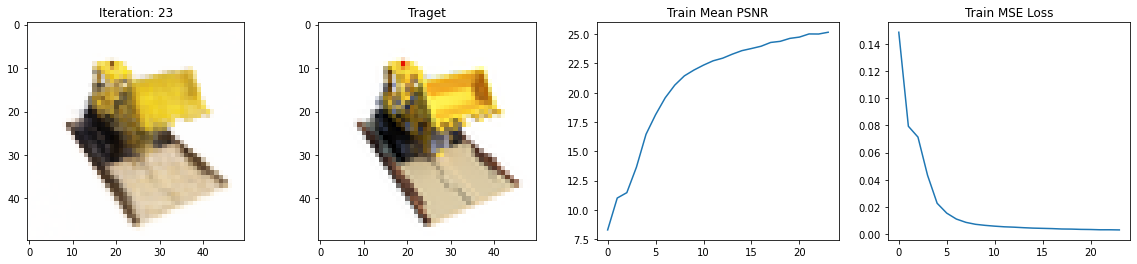

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


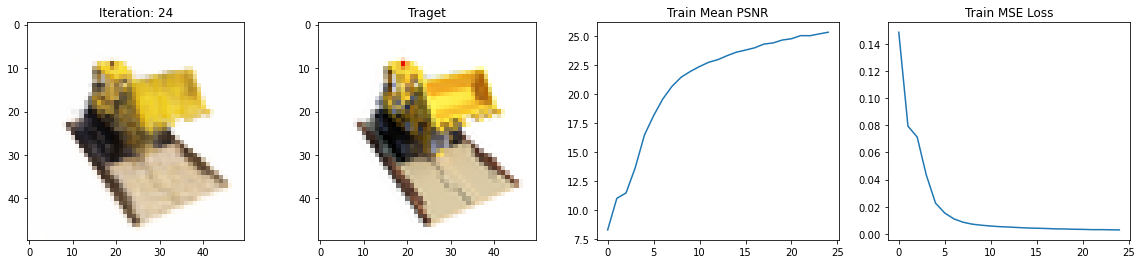

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


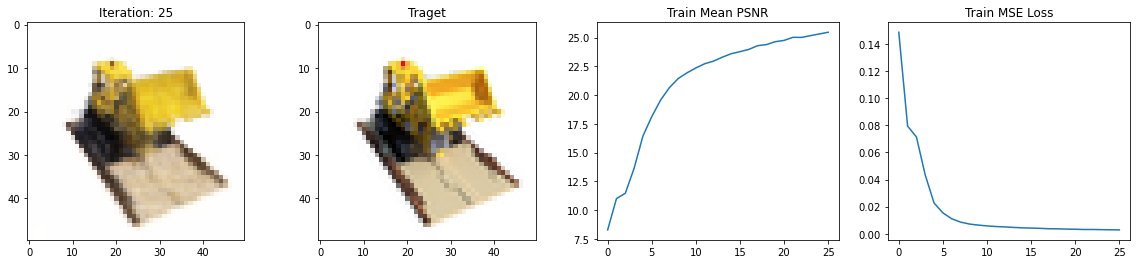

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


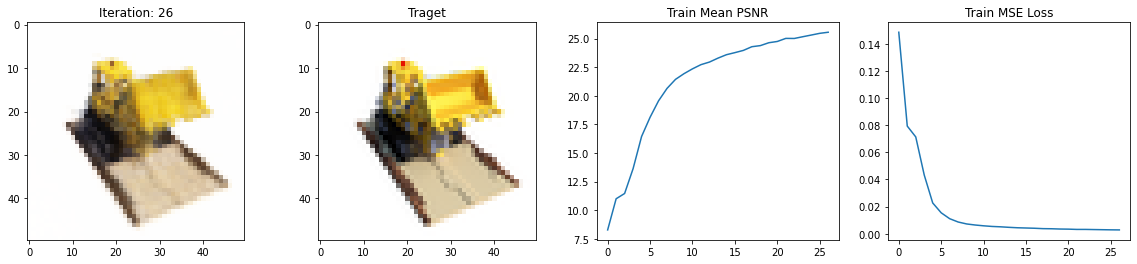

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


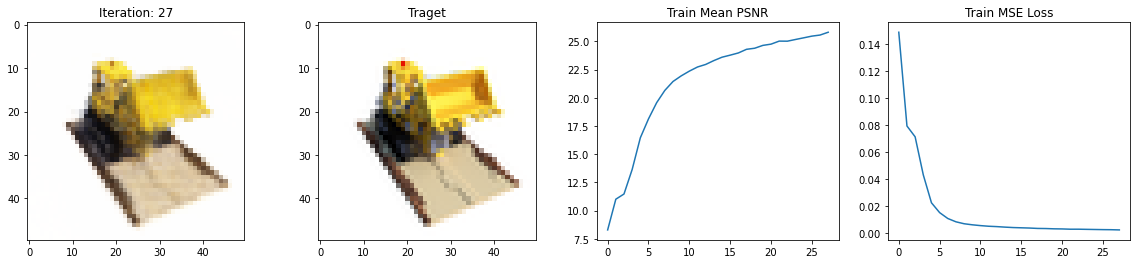

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


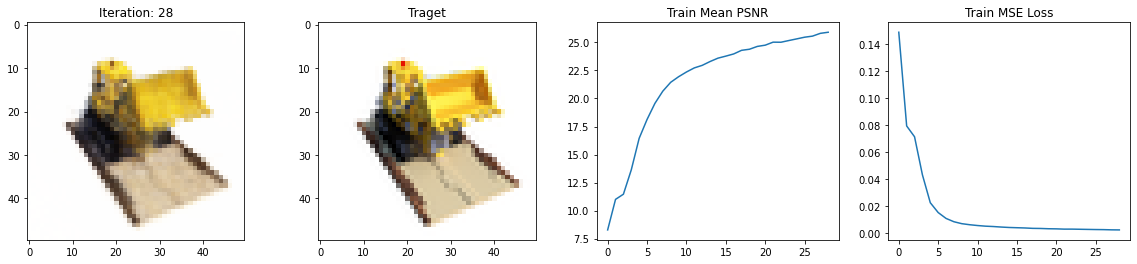

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


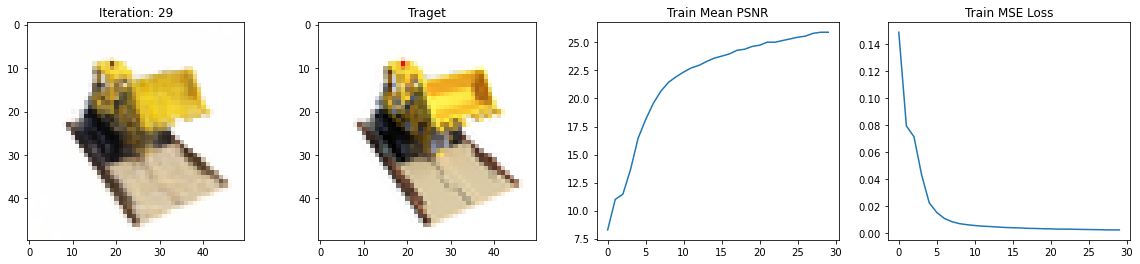

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


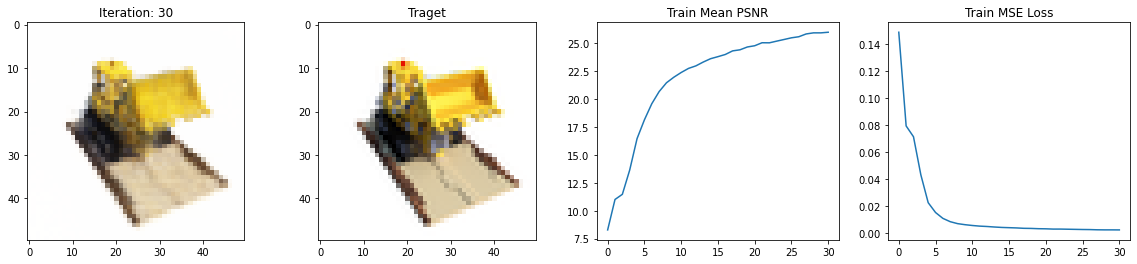

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


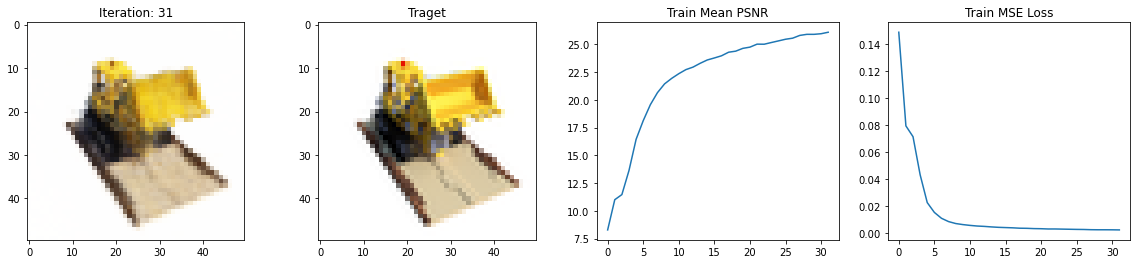

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


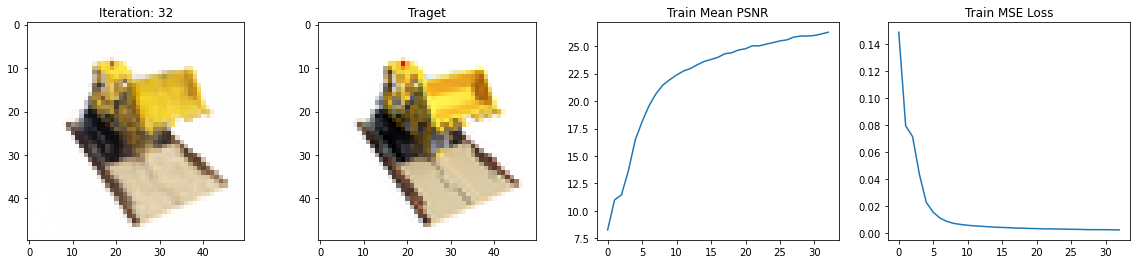

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


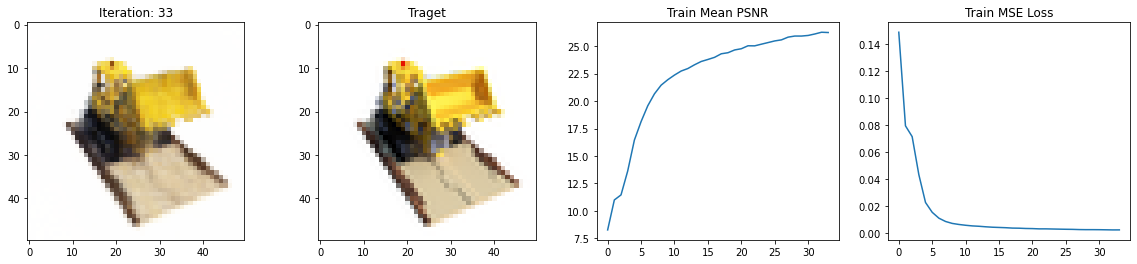

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


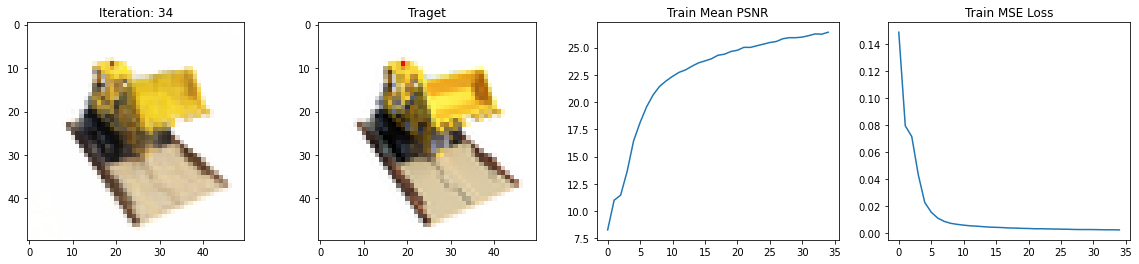

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


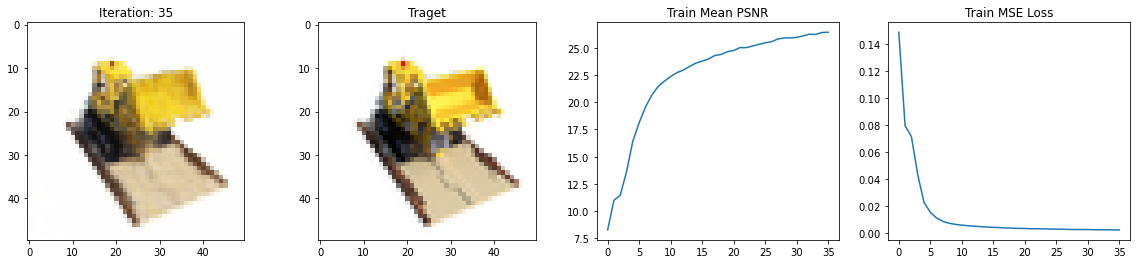

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


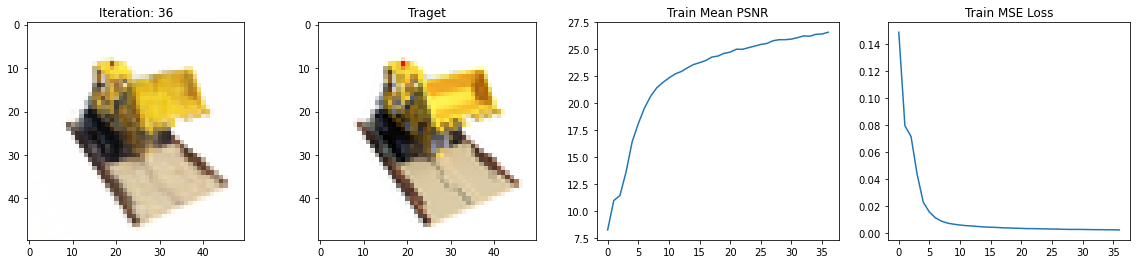

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


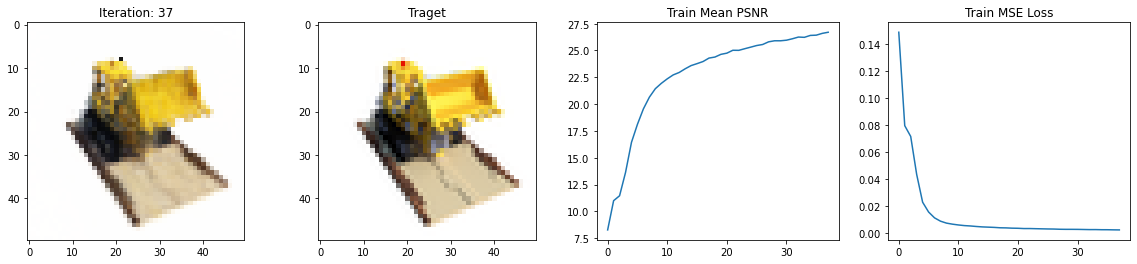

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


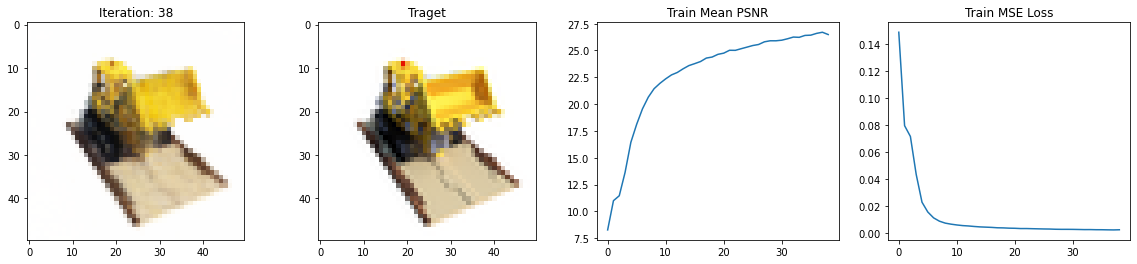

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


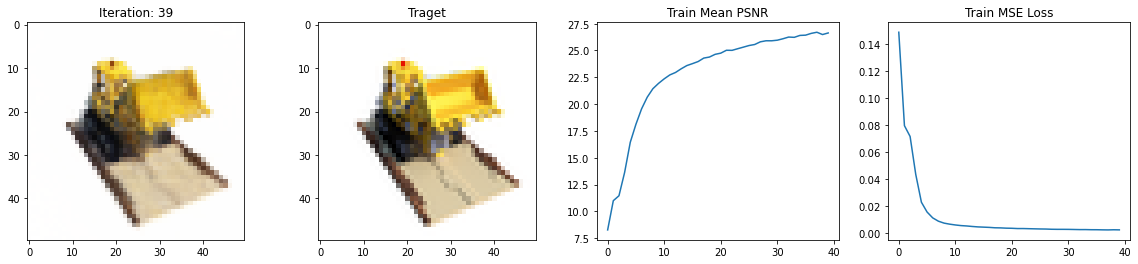

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


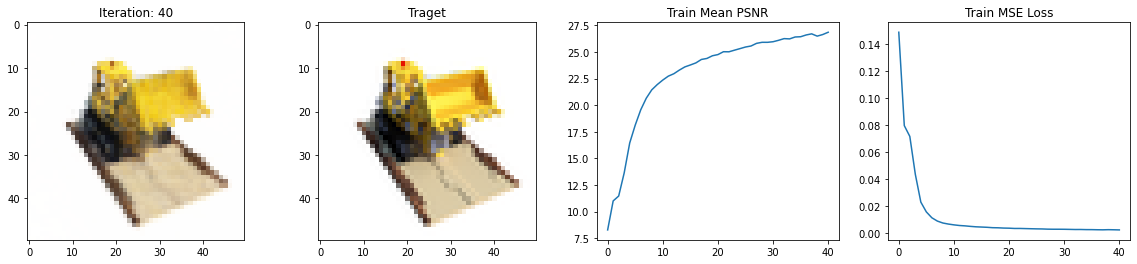

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


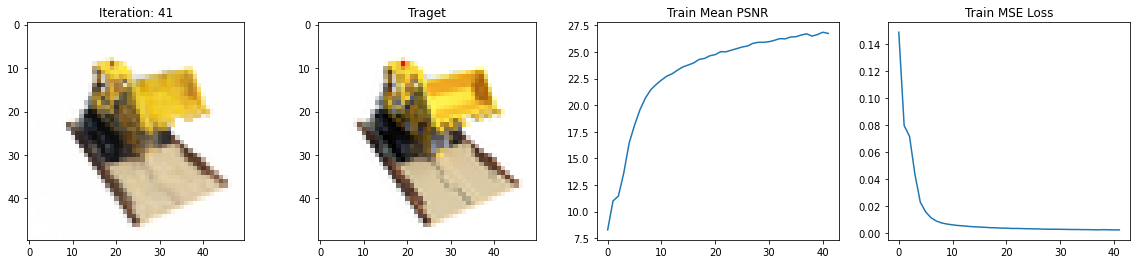

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


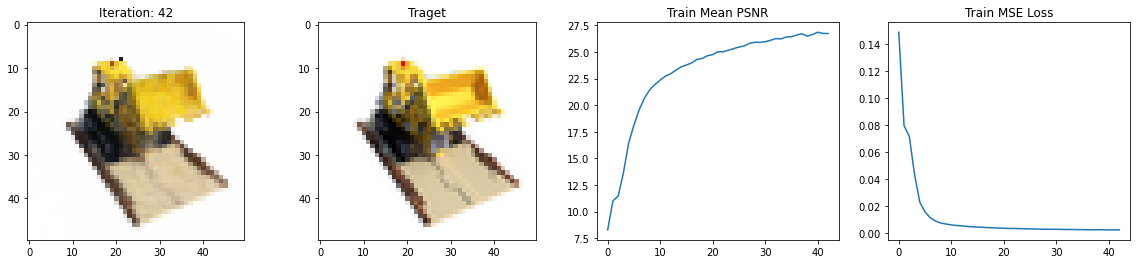

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


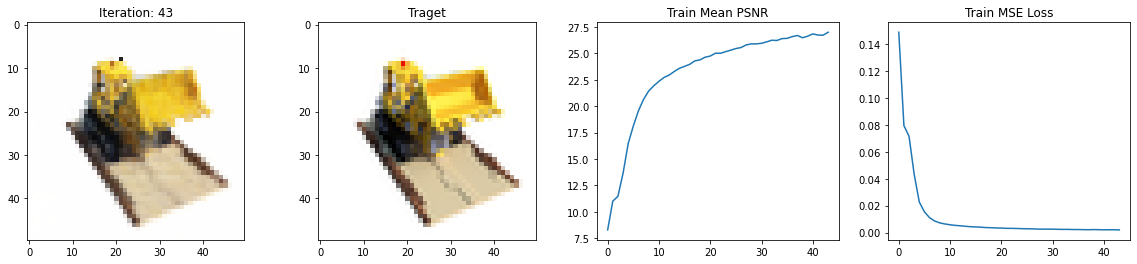

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


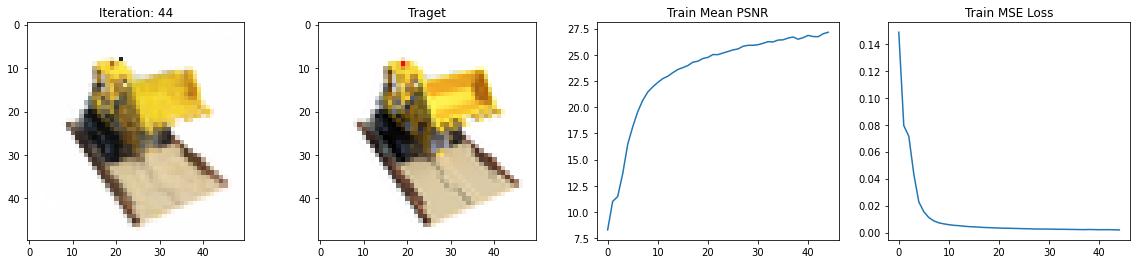

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


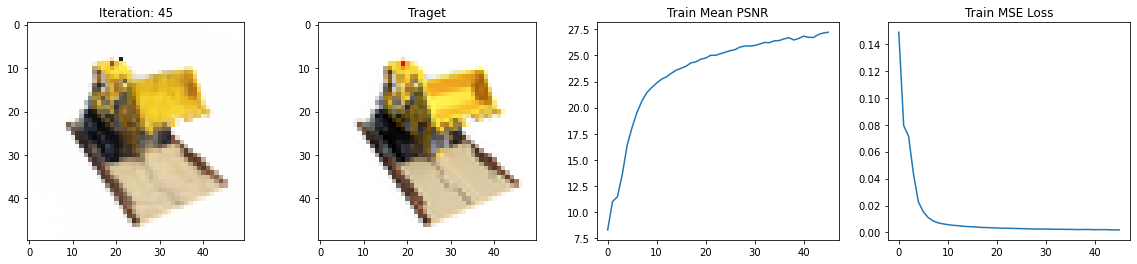

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


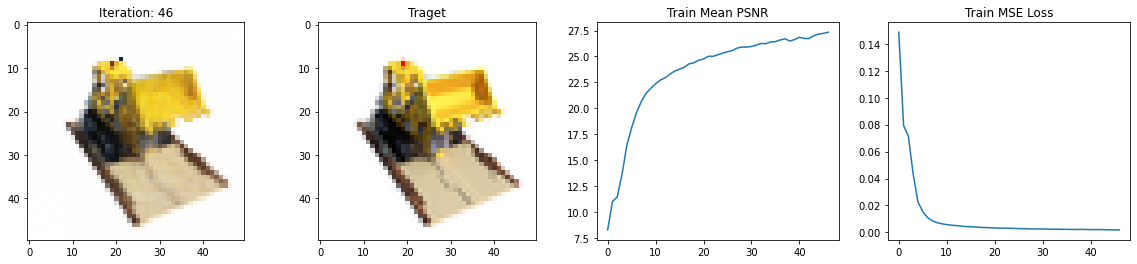

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


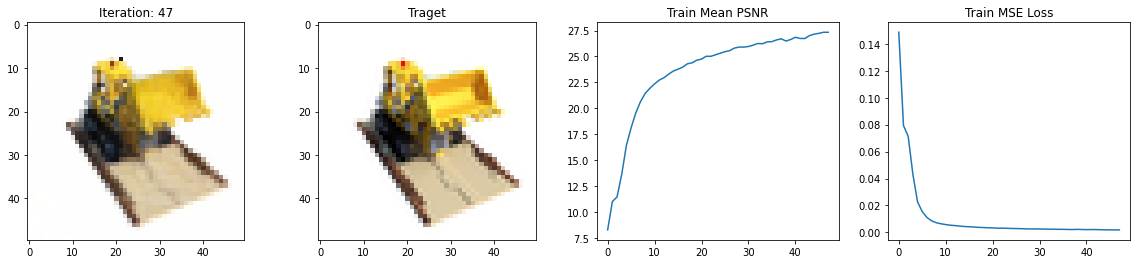

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


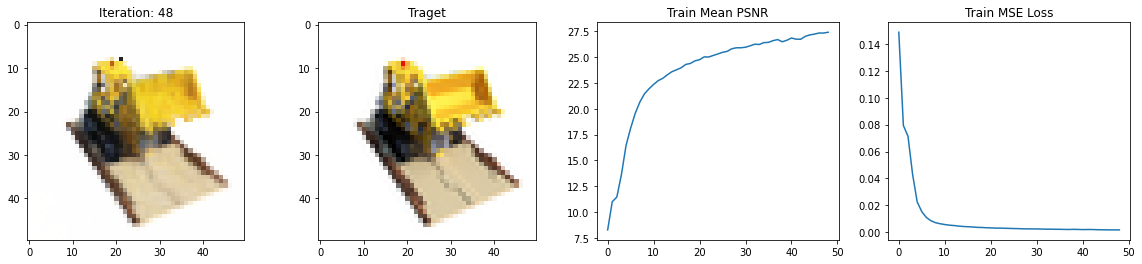

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


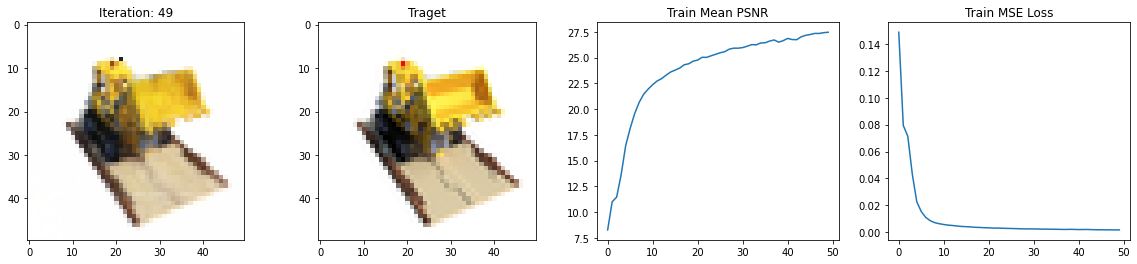

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


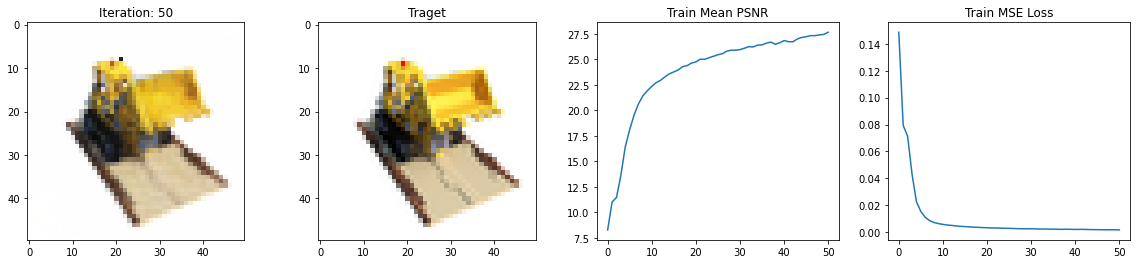

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


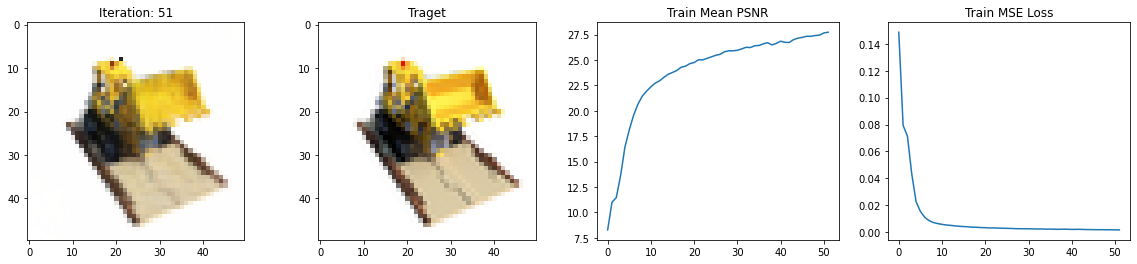

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


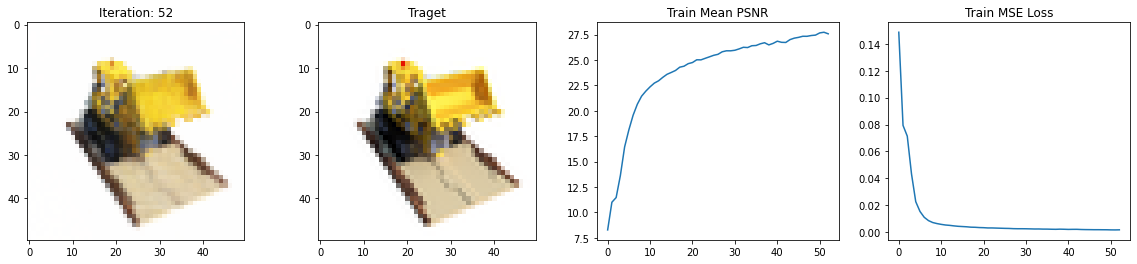

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


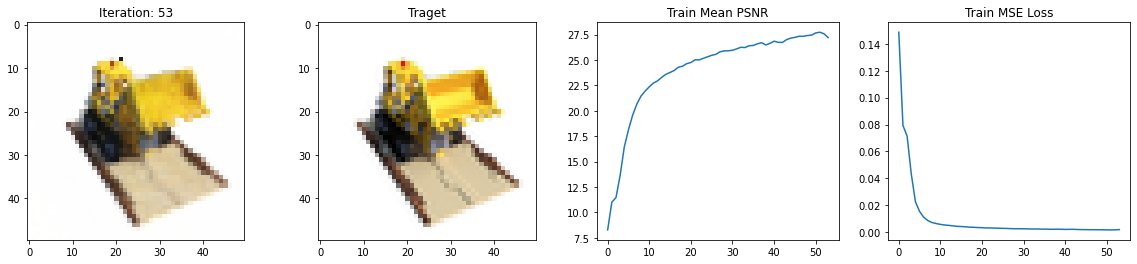

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


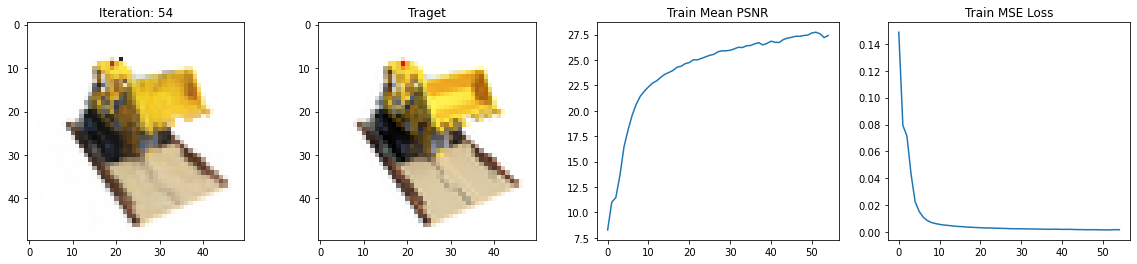

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


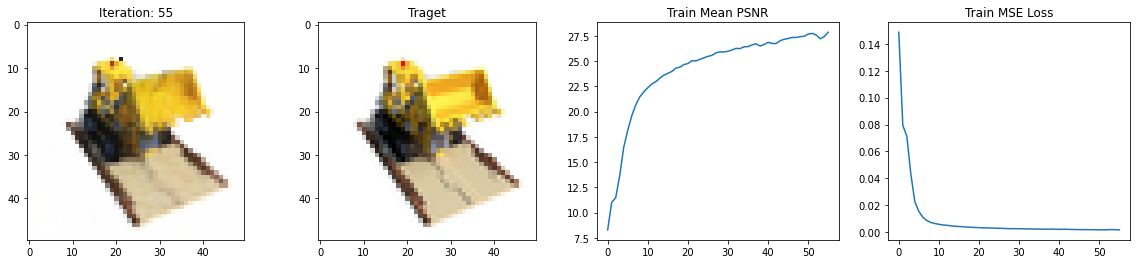

KeyboardInterrupt: 

In [9]:
# ========== TRAINING ==========
model, fine_model = train(use_fine_model=False, restart=True)

In [12]:
# ========== VISUALIZATION AS 360° GIF ==========
import imageio

fine_model = None

if PATH_TO_FINE_MODEL:
    fine_model = Tiny_NeRF(DENSE_LAYER_SIZE)
    fine_model.load_state_dict(torch.load(PATH_TO_FINE_MODEL))
    fine_model.eval()
    fine_model.to(DEVICE)

model = Tiny_NeRF(DENSE_LAYER_SIZE)
model.load_state_dict(torch.load(PATH_TO_MODEL))
model.eval()
model.to(DEVICE)

# Important: shuffle=False and batch_size=H*W, so we can easily reconstruct the predicted image
test_dataloader = DataLoader(test_dataset,
                             shuffle=False,
                             batch_size=H*W)

# Create frames and transform into gif.
with imageio.get_writer(PATH_TO_GIF, mode='I') as writer:
    with torch.no_grad():
        for _, batch in enumerate(test_dataloader):
            rgb, _, _ = forward(model, fine_model, batch['rays_o'], batch['rays_d'])
            frame = (255*np.clip(rgb.view(H, W, 3).cpu().detach(), 0, 1)).numpy().astype(np.uint8)
            writer.append_data(frame)